<a href="https://colab.research.google.com/github/ArianAmani/Facial-Emotion-Recognition/blob/main/Facial_Expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Recognition

![video](https://drive.google.com/uc?id=1e0RYyw4EyiIsc9jmPyROGNlsz3yuTFWK)

In [ ]:
# Mount drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# This creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

#Navigate to /mydrive/AI-Projects/Facial-Expressions
%cd /mydrive/AI-Projects/Facial-Expressions

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import cv2 as cv
from google.colab.patches import cv2_imshow

import time
from io import BytesIO
import IPython.display
from IPython.display import Javascript
import ipywidgets as widgets
import threading
import base64
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import html

# Importing your dataset
You can use any dataset you want.
I'm using [FER-2013](https://www.kaggle.com/msambare/fer2013).

To download from Kaggle to Colab, you need to do the following steps:

In [ ]:
# Get your kaggle.json file from your Kaggle account
# Upload your kaggle.json file
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download your dataset from Kaggle
! mkdir data
%cd data
! kaggle datasets download -d msambare/fer2013
! unzip fer2013.zip
%cd ..

# Reading the data and prepairing it

In [3]:
train_path = 'data/train/'
test_path = 'data/test/'
dim = 48 # our data's image dimensions

Let's choose a random picture from our happy training set and visualize it along it's dimensions

In [4]:
files=os.listdir(train_path + 'happy/')
d=random.choice(files)
d

'Training_60245031.jpg'

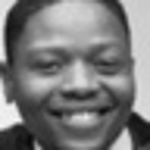

(48, 48)

In [6]:
sample = Image.open('data/train/happy/' + d)
display(sample.resize((150, 150)))
display(sample.size)

---

We'll do some data augmentation on our data and then load the data into `training_set` and `test_set`

In [7]:
train_datagen = ImageDataGenerator(rotation_range=20, rescale=1./255,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  zoom_range=0.2, shear_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path, target_size=(48, 48),
                                                 batch_size=64, class_mode='categorical',
                                                 color_mode='grayscale', shuffle=True)

test_set = test_datagen.flow_from_directory(test_path, target_size=(48, 48),
                                                 batch_size=64, class_mode='categorical',
                                                 color_mode='grayscale', shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
# Create a list of our classes ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
labels = list(training_set.class_indices)



---
# The Convolutional Neural Network

We now create a model to learn on it.
This is a model I created, you can create your own model, use this, or use any model you find on the internet

In [10]:
def create_model():
  model = Sequential()
  inputShape = (dim, dim, 1)

  model.add(Conv2D(64, (3, 3), padding='same', input_shape=inputShape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(GlobalAveragePooling2D())

  model.add(Dropout(.4))

  model.add(Dense(7, activation='softmax'))

  return model

I'm using `Adam` as my optimizer, you can tweak your model to find the best results for yourself

In [11]:
model = create_model()
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Let's get a summary of our model

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0

Let's plot the model now

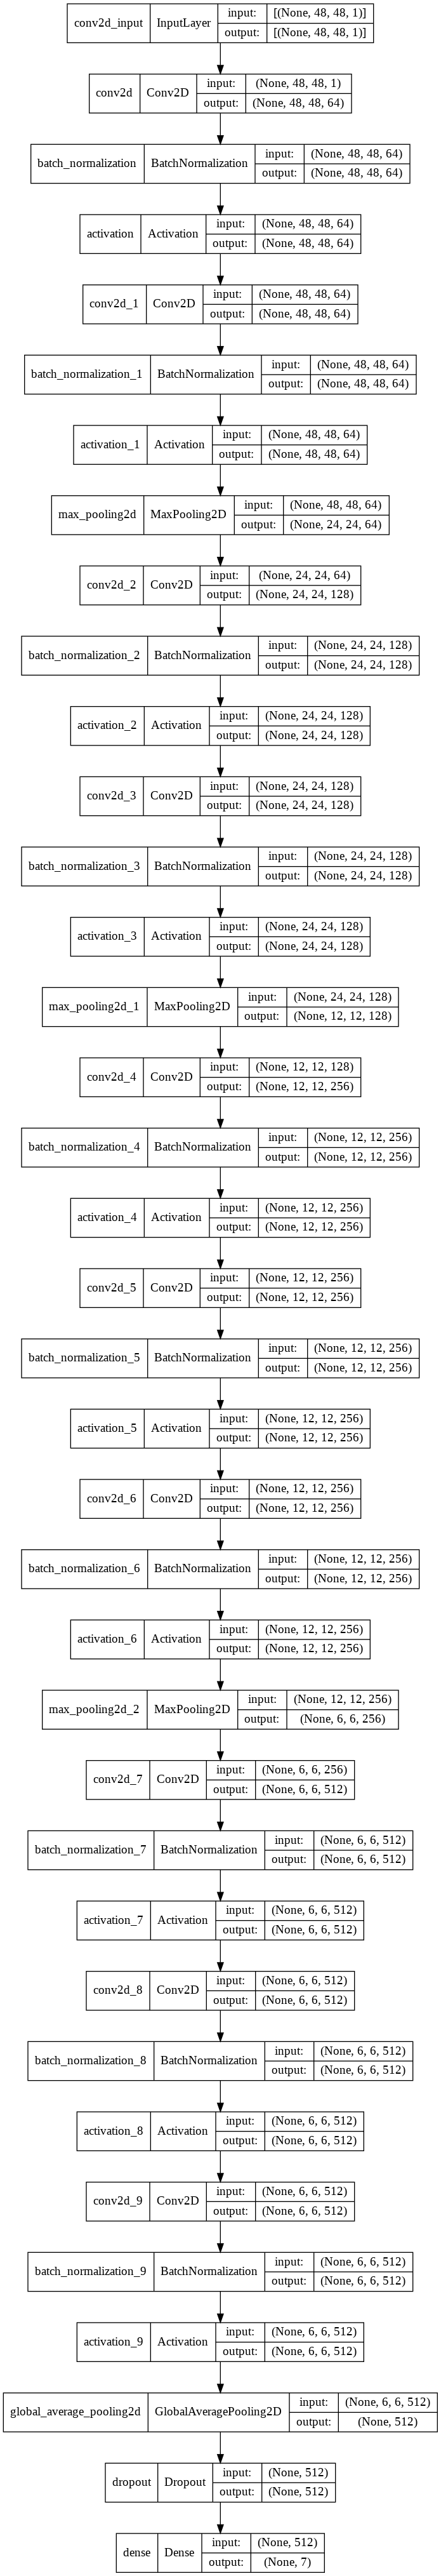

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)



---

Create your CallBack functions

I actually used the functions from [this](https://www.kaggle.com/anantgupt/facial-emotion-recogination-91-accuracy-train-set?scriptVersionId=44278199&cellId=19) notebook

In [ ]:
chk_path = 'weights.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [14]:
STEP_SIZE_TRAIN = training_set.n // training_set.batch_size
STEP_SIZE_VALID = test_set.n // test_set.batch_size

**If you get disconnected or intrrupted for any reason while training, you can always load your latest weights from the last training(thanks to the checkpoint function) and resume training from where you left off using the code cell below**

In [15]:
model.load_weights('weights.h5')

Now let's train our model :))

In [ ]:
with tf.device('/device:GPU:0'):
  hist = model.fit(x=training_set, validation_data=test_set, epochs=60, callbacks=callbacks, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID)
  model.save_weights('my_best_weights.h5')

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.6730
Epoch 00001: val_loss improved from inf to 1.00605, saving model to weights.h5
448/448 [==============================] - 5567s 12s/step - loss: 0.8752 - accuracy: 0.6730 - val_loss: 1.0061 - val_accuracy: 0.6362 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 0.8617 - accuracy: 0.6793
Epoch 00002: val_loss did not improve from 1.00605
448/448 [==============================] - 89s 199ms/step - loss: 0.8617 - accuracy: 0.6793 - val_loss: 1.0720 - val_accuracy: 0.6102 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.6782
Epoch 00003: val_loss did not improve from 1.00605
448/448 [==============================] - 88s 197ms/step - loss: 0.8583 - accuracy: 0.6782 - val_loss: 1.0207 - val_accuracy: 0.6257 - lr: 1.0000e-04
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 0.8503 -



---

# Results

So my training actually got interrupted onec, so I downloaded my training logs after the first part and resumed my training, and after it was done, I concatenated both files to get a full log of my training process

In [16]:
hist1 = pd.read_csv('training1.log')
hist2 = pd.read_csv('training2.log')

In [17]:
full_hist = pd.concat([hist1, hist2], ignore_index=True)

In [18]:
full_hist

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.284098,1.792134,1.000000e-04,0.358398,1.656113
1,1,0.410054,1.524932,1.000000e-04,0.379185,1.693760
2,2,0.477466,1.367742,1.000000e-04,0.329939,1.702713
3,3,0.513528,1.282836,1.000000e-04,0.513532,1.299045
4,4,0.536010,1.228139,1.000000e-04,0.517997,1.225665
...,...,...,...,...,...,...
82,55,0.768860,0.623826,2.560000e-10,0.681362,0.943694
83,56,0.772386,0.625062,2.560000e-10,0.680804,0.940767
84,57,0.769105,0.624785,2.560000e-10,0.681083,0.942946
85,58,0.771548,0.623738,2.560000e-10,0.681920,0.941142


As you see, my epoch column is not correct, due to starting the training again after the interruption, it went back to epoch 1

So let's fix that

In [19]:
full_hist['epoch'] = full_hist.index.tolist()

In [20]:
full_hist

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.284098,1.792134,1.000000e-04,0.358398,1.656113
1,1,0.410054,1.524932,1.000000e-04,0.379185,1.693760
2,2,0.477466,1.367742,1.000000e-04,0.329939,1.702713
3,3,0.513528,1.282836,1.000000e-04,0.513532,1.299045
4,4,0.536010,1.228139,1.000000e-04,0.517997,1.225665
...,...,...,...,...,...,...
82,82,0.768860,0.623826,2.560000e-10,0.681362,0.943694
83,83,0.772386,0.625062,2.560000e-10,0.680804,0.940767
84,84,0.769105,0.624785,2.560000e-10,0.681083,0.942946
85,85,0.771548,0.623738,2.560000e-10,0.681920,0.941142


Good

Now let's plot our process and see how the loss and the accuracy changed on the training and the test set over epochs

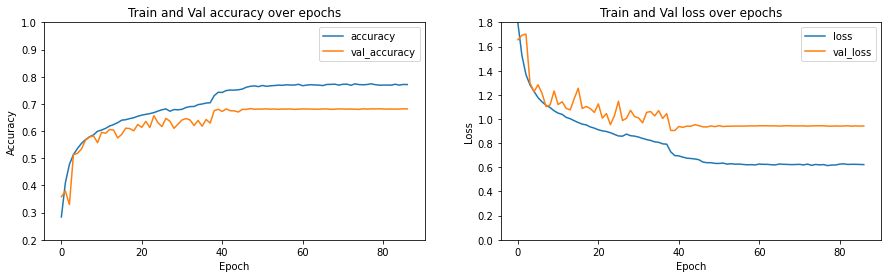

In [21]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 4)

ax[0].plot('epoch', 'accuracy', data=full_hist)
ax[0].plot('epoch', 'val_accuracy', data=full_hist)
ax[0].set(xlabel='Epoch', ylabel='Accuracy', title='Train and Val accuracy over epochs', ylim=[.2, 1])
ax[0].legend()

ax[1].plot('epoch', 'loss', data=full_hist)
ax[1].plot('epoch', 'val_loss', data=full_hist)
ax[1].set(xlabel='Epoch', ylabel='Loss', title='Train and Val loss over epochs', ylim=[0, 1.8])
ax[1].legend()

plt.show()

As you see, our model didn't change much after epoch 50

So let's plot only the first 50 epochs

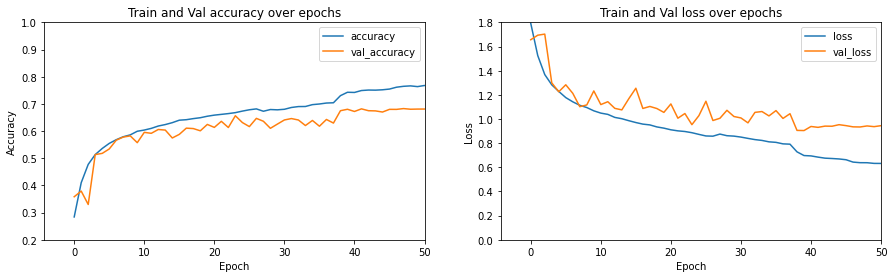

In [22]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 4)

ax[0].plot('epoch', 'accuracy', data=full_hist)
ax[0].plot('epoch', 'val_accuracy', data=full_hist)
ax[0].set(xlabel='Epoch', ylabel='Accuracy', title='Train and Val accuracy over epochs', ylim=[.2, 1])
ax[0].set_xlim(right=50)
ax[0].legend()

ax[1].plot('epoch', 'loss', data=full_hist)
ax[1].plot('epoch', 'val_loss', data=full_hist)
ax[1].set(xlabel='Epoch', ylabel='Loss', title='Train and Val loss over epochs', ylim=[0, 1.8])
ax[1].set_xlim(right=50)
ax[1].legend()

plt.show()

In [ ]:
train_loss, train_accuracy = model.evaluate(training_set)
test_loss, test_accuracy = model.evaluate(test_set)

print('Final results on the training data: Accuracy = {:.2f} , Loss = {:.2f}'.format(train_accuracy * 100, train_loss))
print('Final results on the test data: Accuracy = {:.2f} , Loss = {:.2f}'.format(test_accuracy * 100, test_loss))

113/113 [==============================] - 13s 116ms/step - loss: 0.9426 - accuracy: 0.6817
Final results on the training data: Accuracy = 78.00 , Loss = 0.59
Final results on the test data: Accuracy = 68.17 , Loss = 0.94




---


So this was the best results I got on my model, maybe you could get better results with a better and deeper model and also with some better data


---


# Now we want to use the trained model on real life pictures

**So this is what I've done:**

I'm using cv2's `CascadeClassifier` to detect faces in the input picture, and then, I give the face to the model and it will predict the facial expression of the person in the picture

Then, I'll draw boxes around the faces with the predicted label alongside

In [27]:
face_detector = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

# You can use an image's path or the image object itself
def predict(img=None, img_path=None):
    
    if img_path is not None:
        img = cv.imread(img_path)

    faces = face_detector.detectMultiScale(img, 1.3, 4)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    for (x, y, w, h) in faces:
        face = gray[y:y + h, x:x + w]
        face_resized = cv.resize(face, (48, 48))
        final_face = np.expand_dims(face_resized, axis=0)
        final_face = final_face.reshape(1, 48, 48, 1)
        final_face = final_face / 255
        emotion = model.predict(final_face)
        emotion = labels[np.argmax(emotion)]

        color = (128,0,128)
        text_color = (0,0,0)
        cv.rectangle(img, (x, y), (x+w, y+h), color, 2) # red rectangle
        (w, h), _ = cv.getTextSize(emotion, cv.FONT_HERSHEY_TRIPLEX, 1, 1)

        cv.rectangle(img, (x, y - 20), (x + w, y), color, -1)
        cv.putText(img, emotion, (x, y - 5), cv.FONT_HERSHEY_TRIPLEX, 1, text_color, 1)
        
################## Uncomment the following lines for using on a single picture ##################
##################       Comment to use on a webcam or to use on videos        ##################

    # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # img = cv.resize(img, (3*img.shape[1], 3*img.shape[0]))
    # fig, ax = plt.subplots()
    # fig.set_size_inches(9, 9)
    # ax.axis('off')
    # ax.imshow(img)
    
    return img

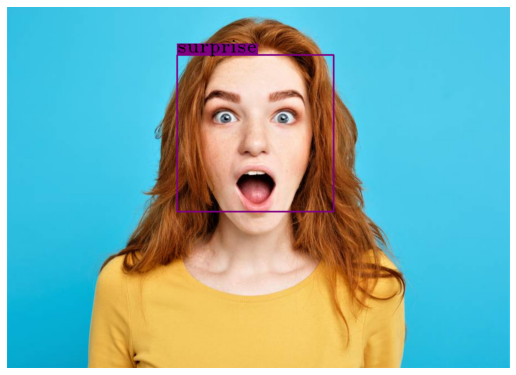

In [25]:
prd = predict(img_path = 'surprised.jpeg')

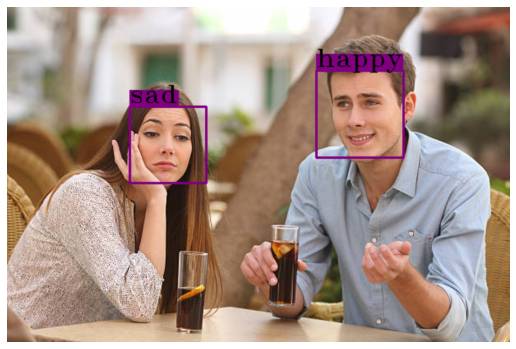

In [26]:
prd = predict(img_path = 'happy_sad.jpg')

# Use the following cells to run the model on a live video from your webcam on Colab

I found the code to run it on Colab [here](https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing)(uh this really helped) and changed it a little to be able to use it on my model

![Me, being surprised :)))](https://drive.google.com/uc?id=1weqkje456Bgv9YLRkEYvmZMCSFIouusF)

In [42]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
  iobuf = BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [47]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [48]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    faces = face_detector.detectMultiScale(img, 1.3, 4)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    for (x, y, w, h) in faces:
        face = gray[y:y + h, x:x + w]
        face_resized = cv.resize(face, (48, 48))
        final_face = np.expand_dims(face_resized, axis=0)
        final_face = final_face.reshape(1, 48, 48, 1)
        final_face = final_face / 255
        emotion = model.predict(final_face)
        emotion = labels[np.argmax(emotion)]

        color = (128,0,128)
        text_color = (0,0,0)
        cv.rectangle(bbox_array, (x, y), (x+w, y+h), color, 2) # red rectangle
        (w, h), _ = cv.getTextSize(emotion, cv.FONT_HERSHEY_TRIPLEX, 1, 1)

        cv.rectangle(bbox_array, (x, y - 20), (x + w, y), color, -1)
        cv.putText(bbox_array, emotion, (x, y - 5), cv.FONT_HERSHEY_TRIPLEX, 1, text_color, 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# And if you're running this on your computer, not on Colab, use this code to run the classifier live on your webcam

In [ ]:
from IPython.display import clear_output, Image, display, HTML
import base64

def arrayShow(imageArray):
    ret, png = cv.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=png)

video = cv.VideoCapture(0)

while(True):
    try:
        clear_output(wait=True)
        _, frame = video.read()
        frame = cv.flip(frame, 1)
        frame = predict(img=frame)
        lines, columns, _ = frame.shape
        frame = cv.resize(frame, (int(columns/2), int(lines/2)))
        img = arrayShow(frame)
        display(img)
    except KeyboardInterrupt:
        break
video.release()
clear_output()

# And at last, you can run your model on a video and get the results back in another video file `output.avi`
The video at the top of the notebook is generated using this function

In [50]:
def video_prediction(video_path):
    inp = cv.VideoCapture(video_path)
    fps = inp.get(cv.CAP_PROP_FPS)
    success,image = inp.read()

    height, width, layers = image.shape
    out = cv.VideoWriter('output.avi', cv.VideoWriter_fourcc('M','J','P','G'), fps, (width,height))

    count = 0
    while success:
        image = predict(image)
        out.write(image)
        success,image = inp.read()

    video.release()

In [ ]:
video_prediction('video.mp4')